### Setup database connectivity

We'll reuse our module from the previous notebook (***`00_database_connectivity_setup.ipynb`***) to establish connectivity to the database

In [1]:
%run '00_database_connectivity_setup.ipynb'
IPython.display.clear_output()

### Load UCI Wine Quality dataset 

We'll use the [UCI Wine Quality dataset](https://archive.ics.uci.edu/ml/datasets/Wine+Quality) for our demos.
```
Attribute Information:

For more information, read [Cortez et al., 2009]. 
Input variables (based on physicochemical tests): 
1 - fixed acidity 
2 - volatile acidity 
3 - citric acid 
4 - residual sugar 
5 - chlorides 
6 - free sulfur dioxide 
7 - total sulfur dioxide 
8 - density 
9 - pH 
10 - sulphates 
11 - alcohol 
Output variable (based on sensory data): 
12 - quality (score between 0 and 10)
```

In [2]:
%%time
%%bash
mkdir -p /tmp/postgresopen_2017
if [ ! -f /tmp/postgresopen_2017/winequality-white.csv ]; then
    echo "Fetching UCI Wine Quality dataset"
    curl https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv > /tmp/postgresopen_2017/winequality-white.csv
fi
ls -l /tmp/postgresopen_2017/winequality-white.csv

-rw-rw-r-- 1 vatsan vatsan 264426 Sep  3 13:35 /tmp/postgresopen_2017/winequality-white.csv
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 24.8 ms


In [3]:
%%time
%%execsql
drop table if exists wine_sample;
create table wine_sample
(
    id serial,
    fixed_acidity float8,
    volatile_acidity float8,
    citric_acid float8,
    residual_sugar float8,
    chlorides  float8,
    free_sulfur_dioxide float8,
    total_sulfur_dioxide float8,
    density float8,
    ph float8,
    sulphates float8,
    alcohol float8,
    quality float8
);
copy 
wine_sample
(
    fixed_acidity,
    volatile_acidity,
    citric_acid,
    residual_sugar,
    chlorides,
    free_sulfur_dioxide,
    total_sulfur_dioxide,
    density,
    ph,
    sulphates,
    alcohol,
    quality
) from '/tmp/postgresopen_2017/winequality-white.csv' WITH DELIMITER ';' CSV HEADER;

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 34.9 ms


In [4]:
%%time
%%showsql
select
    *
from
    wine_sample
limit 10;

,id,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,2,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,3,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,5,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
5,6,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
6,7,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6.0
7,8,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
8,9,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
9,10,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6.0


CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 55.2 ms


In [5]:
%%time
%%showsql
select
    id,
    ARRAY[
        1, -- Bias/intercept
        fixed_acidity,
        volatile_acidity,
        citric_acid,
        residual_sugar,
        chlorides,
        free_sulfur_dioxide,
        total_sulfur_dioxide,
        density,
        ph,
        sulphates,
        alcohol
    ] as features,
    quality
from
    wine_sample
limit 10;

,id,features,quality
0,1,"[1.0, 7.0, 0.27, 0.36, 20.7, 0.045, 45.0, 170.0, 1.001, 3.0, 0.45, 8.8]",6.0
1,2,"[1.0, 6.3, 0.3, 0.34, 1.6, 0.049, 14.0, 132.0, 0.994, 3.3, 0.49, 9.5]",6.0
2,3,"[1.0, 8.1, 0.28, 0.4, 6.9, 0.05, 30.0, 97.0, 0.9951, 3.26, 0.44, 10.1]",6.0
3,4,"[1.0, 7.2, 0.23, 0.32, 8.5, 0.058, 47.0, 186.0, 0.9956, 3.19, 0.4, 9.9]",6.0
4,5,"[1.0, 7.2, 0.23, 0.32, 8.5, 0.058, 47.0, 186.0, 0.9956, 3.19, 0.4, 9.9]",6.0
5,6,"[1.0, 8.1, 0.28, 0.4, 6.9, 0.05, 30.0, 97.0, 0.9951, 3.26, 0.44, 10.1]",6.0
6,7,"[1.0, 6.2, 0.32, 0.16, 7.0, 0.045, 30.0, 136.0, 0.9949, 3.18, 0.47, 9.6]",6.0
7,8,"[1.0, 7.0, 0.27, 0.36, 20.7, 0.045, 45.0, 170.0, 1.001, 3.0, 0.45, 8.8]",6.0
8,9,"[1.0, 6.3, 0.3, 0.34, 1.6, 0.049, 14.0, 132.0, 0.994, 3.3, 0.49, 9.5]",6.0
9,10,"[1.0, 8.1, 0.22, 0.43, 1.5, 0.044, 28.0, 129.0, 0.9938, 3.22, 0.45, 11.0]",6.0


CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 29.3 ms


In [6]:
%%time
%%execsql
--1) Define model return type record
drop type if exists host_mdl_coef_intercept CASCADE;
create type host_mdl_coef_intercept
AS
(
    hostname text, -- hostname on which the model was built
    coef float[], -- model coefficients
    intercept float, -- intercepts
    r_square float -- training data fit
);

--2) Define a UDA to concatenate arrays
drop aggregate if exists array_agg_array(anyarray) CASCADE;
create aggregate array_agg_array(anyarray)
(
    SFUNC = array_cat,
    STYPE = anyarray
);

--3) Define PL/Python function to train ridge regression model
create or replace function sklearn_ridge_regression(
    features_mat float8[],
    n_features int,
    labels float8[]
)
returns host_mdl_coef_intercept
as
$$
    import os
    from sklearn import linear_model
    import numpy as np
    X = np.array(features_mat).reshape(int(len(features_mat)/n_features), int(n_features))
    y = np.array(labels).transpose()
    mdl = linear_model.Ridge(alpha = .5)
    mdl.fit(X, y)
    result = [
        os.popen('hostname').read().strip(), 
        mdl.coef_, 
        mdl.intercept_, 
        mdl.score(X, y)
    ] 
    return result
$$language plpython3u;

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 55.6 ms


In [7]:
%%showsql
select
    (
        sklearn_ridge_regression(
            features_mat,
            n_features,
            labels
        )
    ).*
from
(
    select
        -- Convert rows of features into a large linear array
        array_agg_array(features order by id) as features_mat,
        -- Number of features
        max(array_upper(features, 1)) as n_features,
        -- Gather all the Labels
        array_agg(quality order by id) as labels
    from
    (
        select
            id,
            1 as grouping,
            -- Create a feature vector of independent variables
            ARRAY[
                1, -- Bias/intercept
                fixed_acidity,
                volatile_acidity,
                citric_acid,
                residual_sugar,
                chlorides,
                free_sulfur_dioxide,
                total_sulfur_dioxide,
                density,
                ph,
                sulphates,
                alcohol
            ] as features,
            quality
        from
            wine_sample
    )q1
    group by
        grouping
)q2

,hostname,coef,intercept,r_square
0,vatsan-ubuntu,"[0.0, -0.0495253754159579, -1.94106001138037, -0.0294681847962651, 0.0258746158138702, -0.766597139523927, 0.00479549488638412, -0.000888020677675256, -0.469010277464961, 0.169524831918536, 0.417194189911568, 0.363109379777526]",2.494115,0.272781


### MAX_FIELD_SIZE (1GB) Limitation

One limitation with using PL/Python for in-database machine learning in PostgreSQL, is the max_field_size limit of Postgres which disallows UDFs from accepting inputs that exceed 1 GB (ex: a float8[]). While your database table itself could be of the order of hundreds of terabytes in size, no single field (cell) can exceed 1 GB in size. Each row of data could be composed of several hundred columns and collectively a row of data could be really large, but no single column’s value, in a given row can exceed 1 GB.

```
(http://www.postgresql.org/about/)
Limit Value
Maximum Database Size Unlimited
Maximum Table Size  32 TB
Maximum Row Size  1.6 TB
Maximum Field Size  1 GB
Maximum Rows per Table  Unlimited
Maximum Columns per Table 250 - 1600 depending on column types
Maximum Indexes per Table Unlimited
```

In [8]:
%%time
%%execsql
-- An array of 120000000 float8(8 bytes) types = 960 MB
--1) Define UDF to generate large arrays
create or replace function gen_array(x int)
returns float8[]
as
$$
    from random import random
    return [random() for _ in range(x)]
$$language plpython3u;

--2) Create a table
drop table if exists cellsize_test;
create table cellsize_test
as
(
    select
        1 as row,
        y,
        gen_array(12000) as arr
    from
        generate_series(1, 3) y
);

--3) Define a UDA to concatenate arrays
DROP AGGREGATE IF EXISTS array_agg_array(anyarray) CASCADE;
CREATE AGGREGATE array_agg_array(anyarray)
(
    SFUNC = array_cat,
    STYPE = anyarray
);

--4) Define a UDF to consume a really large array and return its size
create or replace function consume_large_array(x float8[])
returns text
as
$$
    return 'size of x:{0}'.format(len(x))
$$language plpython3u;

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 119 ms


In [9]:
%%time
%%showsql
--5) Invoke the UDF & UDA to demonstrate failure due to max_fieldsize_limit
select
    row,
    consume_large_array(arr)
from
(

    select
        row,
        array_agg_array(arr) as arr
    from
        cellsize_test
    group by
        row
)q;

,row,consume_large_array
0,1,size of x:36000


CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 16.8 ms


For data science problems we often work with datasets/matrices that exceed the max_field_size limit. For instance, in the example here: [gp_xgboost_gridsearch](https://github.com/vatsan/gp_xgboost_gridsearch), several XGBoost models are built in parallel for every possible combination of the input parameters. If the input dataset exceeds 1 GB in size, these UDFs would error out due to the violation of the max_fieldsize_limit. This limitation prevents users from harnessing the full power of the database (or MPP cluster) even when the host(s) have a lot more memory than the max_field_size limit.

### Using SD and GD with UDAs to bypass max_fieldsize_limit for building large scale ML models

We’ll next demonstrate how to work-around the max_fieldsize_limit, to write PL/Python UDFs that harness popular machine learning libraries like scikit-learn on datasets several tens to hundreds of gigabytes in size.
All PL/Python UDFs have two dictionaries, `SD` and `GD`, that can be used to cache data in memory.

1. `SD` is private to a UDF, it is used to cache data between function calls in a given transaction.
2. `GD` is global dictionary, it is available to all UDFs within a transaction.

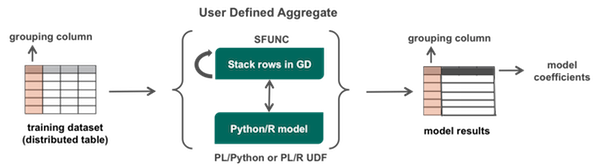

In [12]:
Image(os.environ['PROJECT_HOME'] + '/docs/images/largescale_sklearn_models_mpp.png')

In [8]:
%%time
%%execsql
--1) SFUNC: State transition function, part of a User-Defined-Aggregate definition
-- This function will merely stack every row of input, into the GD variable
drop function if exists stack_rows(
    text,
    text[],
    float8[],
    float8
) cascade;

create or replace function stack_rows(
    key text,
    header text[], -- name of the features column and the dependent variable column
    features float8[], -- independent variables (as array)
    label float8 -- dependent variable column
)
returns text
as
$$
    if 'header' not in GD:
        GD['header'] = header
    if not key:
        gd_key = 'stack_rows'
        GD[gd_key] = [[features, label]]
        return gd_key
    else:
        GD[key].append([features, label])
        return key
$$language plpython3u;

--2) Define the User-Defined Aggregate (UDA) consisting of a state-transition function (SFUNC), a state variable and a FINALFUNC (optional)
drop aggregate if exists stack_rows( 
    text[], -- header (feature names)
    float8[], -- features (feature values),
    float8 -- labels
) cascade;
create aggregate stack_rows(
        text[], -- header (feature names)
        float8[], -- features (feature values),
        float8 -- labels
    )
(
    SFUNC = stack_rows,
    STYPE = text -- the key in GD used to hold the data across calls
);

--3) Create a return type for model results
DROP TYPE IF EXISTS host_mdl_coef_intercept CASCADE;
CREATE TYPE host_mdl_coef_intercept
AS
(
    hostname text, -- hostname on which the model was built
    coef float[], -- model coefficients
    intercept float, -- intercepts
    r_square float -- training data fit
);

--4) Define a UDF to run ridge regression by retrieving the data from the key in GD and returning results
drop function if exists run_ridge_regression(text) cascade;
create or replace function run_ridge_regression(key text)
returns host_mdl_coef_intercept
as
$$
    import os
    import numpy as np   
    import pandas as pd
    from sklearn import linear_model
    
    if key in GD:
        df = pd.DataFrame(GD[key], columns=GD['header'])
        mdl = linear_model.Ridge(alpha = .5)
        X = np.mat(df[GD['header'][0]].values.tolist())
        y = np.mat(df[GD['header'][1]].values.tolist()).transpose()
        mdl.fit(X, y)
        result = [
            os.popen('hostname').read().strip(), 
            mdl.coef_[0], 
            mdl.intercept_[0], 
            mdl.score(X, y)
        ]   
        GD[key] = result        
        result = GD[key]
        del GD[key]
        return result
    else:
        plpy.info('returning None')
        return None
$$ language plpython3u;

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.69 ms
